In [173]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table,join
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [281]:
from matplotlib import rcParams as rc
rc.update({'font.size': 18,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 18,\
           'ytick.labelsize' : 18,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [282]:
def list_columns(obj, cols=4, columnwise=True, gap=4):
    """
    Print the given list in evenly-spaced columns.

    Parameters
    ----------
    obj : list
        The list to be printed.
    cols : int
        The number of columns in which the list should be printed.
    columnwise : bool, default=True
        If True, the items in the list will be printed column-wise.
        If False the items in the list will be printed row-wise.
    gap : int
        The number of spaces that should separate the longest column
        item/s from the next column. This is the effective spacing
        between columns based on the maximum len() of the list items.
    """

    sobj = [str(item) for item in obj]
    if cols > len(sobj): cols = len(sobj)
    max_len = max([len(item) for item in sobj])
    if columnwise: cols = int(math.ceil(float(len(sobj)) / float(cols)))
    plist = [sobj[i: i+cols] for i in range(0, len(sobj), cols)]
    if columnwise:
        if not len(plist[-1]) == cols:
            plist[-1].extend(['']*(len(sobj) - len(plist[-1])))
        plist = zip(*plist)
    printer = '\n'.join([
        ''.join([c.ljust(max_len + gap) for c in p])
        for p in plist])
    print(printer)


In [283]:
class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()

In [284]:
def rotate(xx,yy,angle):
    # rotate x and y cartesian coordinates by angle (in degrees)
    # about the point (0,0)
    theta = -1.*angle * np.pi / 180. # in radians
    xx1 = np.cos(theta) * xx - np.sin(theta) * yy
    yy1 = np.sin(theta) * xx + np.cos(theta) * yy
    return xx1, yy1

def make_radec(xx0,yy0,ra,dec,pa):
    xx, yy = rotate(xx0,yy0,pa)
    ra_fib = ra + xx*PLATESCALE/3600./np.cos(dec*np.pi/180.) 
    dec_fib = dec - yy*PLATESCALE/3600. 
    return ra_fib, dec_fib

    
def make_line(wave, r1, sci, wl_shift_vel, whichone):

    # Halpha
    wl_ha = (wave > 6560 + wl_shift_vel/3e5*6560) & (wave < 6570+ wl_shift_vel/3e5*6570)
    iis_ha = np.where(wl_ha)[0]
    ha = np.sum(r1[:,iis_ha],axis=1)[sci]

    wl_ha_cont = (wave > 6600+ wl_shift_vel/3e5*6600) & (wave < 6610+ wl_shift_vel/3e5*6610)
    iis_ha_cont = np.where(wl_ha_cont)[0]
    ha_cont = np.sum(r1[:,iis_ha_cont],axis=1)[sci]
        
        
    # SII doublet

    wl_sii1 = (wave > 6715+ wl_shift_vel/3e5*6715) & (wave < 6725+ wl_shift_vel/3e5*6725)
    iis_sii1 = np.where(wl_sii1)[0]
    sii1 = np.sum(r1[:,iis_sii1],axis=1)[sci]

    wl_sii2 = (wave > 6730+ wl_shift_vel/3e5*6730) & (wave < 6740+ wl_shift_vel/3e5*6740)
    iis_sii2 = np.where(wl_sii2)[0]
    sii2 = np.sum(r1[:,iis_sii2],axis=1)[sci]


    wl_sii_cont = (wave > 6700+ wl_shift_vel/3e5*6700) & (wave < 6710+ wl_shift_vel/3e5*6710)
    iis_sii_cont = np.where(wl_sii_cont)[0]
    sii_cont = np.sum(r1[:,iis_sii_cont],axis=1)[sci]
        
        
    # [SIII]9069

    wl_siii9068 = (wave > 9065+ wl_shift_vel/3e5*9065) & (wave < 9075+ wl_shift_vel/3e5*9075)
    iis_siii9068 = np.where(wl_siii9068)[0]
    siii9068 = np.sum(r1[:,iis_siii9068],axis=1)[sci]
    
    # [OIII]5007
    wl_oiii = (wave > 5000 + wl_shift_vel/3e5*5000) & (wave < 5015+ wl_shift_vel/3e5*5015)
    iis_oiii = np.where(wl_oiii)[0]
    oiii = np.sum(r1[:,iis_oiii],axis=1)[sci]
    
    
    # [OIII]4363    
    wl_oiii4363 = (wave > 4360 + wl_shift_vel/3e5*4360) & (wave < 4365+ wl_shift_vel/3e5*4365)
    iis_oiii4363 = np.where(wl_oiii4363)[0]
    oiii4363 = np.sum(r1[:,iis_oiii4363],axis=1)[sci]

    wl_oiii4363_cont = (wave > 4375+ wl_shift_vel/3e5*4375) & (wave < 4380+ wl_shift_vel/3e5*4380)
    iis_oiii4363_cont = np.where(wl_oiii4363_cont)[0]
    oiii4363_cont = np.sum(r1[:,iis_oiii4363_cont],axis=1)[sci]
   
    # [OII]3727
    wl_oii = (wave > 3720 + wl_shift_vel/3e5*3720) & (wave < 3732+ wl_shift_vel/3e5*3732)
    iis_oii = np.where(wl_oii)[0]
    oii = np.sum(r1[:,iis_oii],axis=1)[sci]
    
    #[NII]5755
    wl_nii5755 = (wave > 5752 + wl_shift_vel/3e5*5752) & (wave < 5758+ wl_shift_vel/3e5*5758)
    iis_nii5755 = np.where(wl_nii5755)[0]
    nii5755 = np.sum(r1[:,iis_nii5755],axis=1)[sci]

    wl_nii5755_cont = (wave > 5710+ wl_shift_vel/3e5*5710) & (wave < 5715+ wl_shift_vel/3e5*5715)
    iis_nii5755_cont = np.where(wl_nii5755_cont)[0]
    nii5755_cont = np.sum(r1[:,iis_nii5755_cont],axis=1)[sci]
    
    wl_nii5755_cont2 = (wave > 5770+ wl_shift_vel/3e5*5770) & (wave < 5775+ wl_shift_vel/3e5*5775)
    iis_nii5755_cont2 = np.where(wl_nii5755_cont2)[0]
    nii5755_cont2 = np.sum(r1[:,iis_nii5755_cont2],axis=1)[sci]
   
    #r band
    wl_r = (wave > 5500 + wl_shift_vel/3e5*5500) & (wave < 6900+ wl_shift_vel/3e5*6900)
    iis_r = np.where(wl_r)[0]
    r = np.sum(r1[:,iis_r],axis=1)[sci]


    if whichone == 'ha':
        return ha
    if whichone == 'ha_sub':
        return ha - ha_cont
    if whichone == 'sii':
        return sii1 + sii2
    if whichone == 'sii_ratio':
        ratio = sii1/sii2
        ratio[sii1+sii2 < 10] = np.nan
        return ratio
    if whichone == 'siii':
        return siii9068
    
    if whichone == 'oiii': 
        return oiii
    
    if whichone == 'oii':
        return oii
    
    if whichone == 'oiii4363':
        return oiii4363 - oiii4363_cont
    
    if whichone == 'nii5755':
        return nii5755 - (nii5755_cont + nii5755_cont2)/2.
   
    if whichone == 'r_cont':
        return r

def read_file(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = DIR_redux + (mjd) + '/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu[1].data
    r1_hdr = rsshdu[1].header
    r1_err = rsshdu[2]

    wave=rsshdu[4].data 

    tab = Table(rsshdu[6].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']


#    print(hdr['OBJECT'],hdr['POSCIPA'])
    #ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['POSCIRA'], hdr['POSCIDE'], hdr['POSCIPA'])
#    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['TESCIRA'], hdr['TESCIDE'], hdr['POSCIPA'])
    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux

def plotty(line_dict, vmin, vmax, title, filename, size=30):
#    size = 30

    fig = plt.figure(figsize=(8,8))
#    for dd in line_dict:
#        d = line_dict[dd]
#        print(dd,d)
    plt.scatter(line_dict['ra_fib'],line_dict['dec_fib'], c =line_dict['line'] ,s=size,vmin = vmin, vmax = vmax)

    plt.title(title)
    plt.xlabel('Ra [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar()

    ax = plt.gca()

    xx = ax.get_xlim()
    plt.xlim(xx[1],xx[0])

    ax.set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()
    fig.savefig('figs/'+filename+'.png')

    plt.close()




In [311]:
def map_plot(line_dict, vmin, vmax, title, filename, size=30,\
             cmap='Spectral', fsize=8, figs_dir='figs'):
#    size = 30
    X=line_dict['ra_fib']
    Y=line_dict['dec_fib']
    C=line_dict['line']
    fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    sc=ax.scatter(X, Y, c=C ,s=size,vmin = vmin, vmax = vmax, cmap=cmap)
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Dec [deg]')
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax,label=fr'${title}$')
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    fig.savefig(f'{figs_dir}/{filename}.png')
    plt.close()
    

def map_plot_DAP(tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk', size=8,\
             cmap='Spectral', fsize=5, figs_dir='figs'):
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]
    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.min(tab_line['line'])
        vmax=np.max(tab_line['line'])
    fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    sc=ax.scatter(X, Y, c=C ,s=size,vmin = vmin, vmax = vmax, cmap=cmap)
    ax.set_xlabel('Ra [deg]')
    ax.set_ylabel('Dec [deg]')
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(sc, cax=cax,label=fr'${title}$')
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    fig.savefig(f'{figs_dir}/{filename}.png')
    plt.close()
#map_plot_DAP(tab_DAP,size=10)#,fsize=5)

In [312]:
# platescale to convert fiber positions from mm to arcsec
PLATESCALE = 112.36748321030637

# directory where reduced cFrames are stored
#DIR_redux = '/data/LVM/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/'
DIR_DAP = 'output_chiripa'


In [313]:
#dap_file='dap-rsp30-00006109.dap.fits.gz'
dap_file='dap-rsp30-00006690.dap.fits.gz'
dap_file=f'{DIR_DAP}/{dap_file}'
dap_hdu=fits.open(dap_file)
#dap_hdu.info()

In [314]:
tab_PT=Table(dap_hdu['PT'].data)
tab_RSP=Table(dap_hdu['RSP'].data)
tab_COEFFS=Table(dap_hdu['COEFFS'].data)
tab_PE=Table(dap_hdu['PM_ELINES'].data)
tab_NPE_B=Table(dap_hdu['NP_ELINES_B'].data)
tab_NPE_R=Table(dap_hdu['NP_ELINES_R'].data)
tab_NPE_I=Table(dap_hdu['NP_ELINES_I'].data)

#
# Rename some entries!
#
tab_RSP.rename_column('Av','Av_st')
tab_RSP.rename_column('e_Av','e_Av_st')
tab_RSP.rename_column('z','z_st')
tab_RSP.rename_column('e_z','e_z_st')
tab_RSP.rename_column('disp','disp_st')
tab_RSP.rename_column('e_disp','e_disp_st')
tab_RSP.rename_column('flux','flux_st')
tab_RSP.rename_column('redshift','redshift_st')
tab_RSP.rename_column('med_flux','med_flux_st')
tab_RSP.rename_column('e_med_flux','e_med_flux_st')
tab_RSP.rename_column('sys_vel','vel_st')
#
# Parametric elines
#
tab_PE.rename_column('flux','flux_pe')
tab_PE.rename_column('e_flux','e_flux_pe')
tab_PE.rename_column('disp','disp_pe')
tab_PE.rename_column('e_disp','e_disp_pe')
tab_PE.rename_column('vel','vel_pe')
tab_PE.rename_column('e_vel','e_vel_pe')
#
# id	id_fib	rsp	TEFF	LOGG	META	ALPHAM	COEFF	Min.Coeff	log(M/L)	AV	N.Coeff	Err.Coeff
#
tab_COEFFS.rename_column('rsp','id_rsp')
tab_COEFFS.rename_column('TEFF','Teff_rsp')
tab_COEFFS.rename_column('LOGG','Log_g_rsp')
tab_COEFFS.rename_column('META','Fe_rsp')
tab_COEFFS.rename_column('ALPHAM','alpha_rsp')
tab_COEFFS.rename_column('COEFF','W_rsp')
tab_COEFFS.rename_column('Min.Coeff','min_W_rsp')
tab_COEFFS.rename_column('log(M/L)','log_ML_rsp')
tab_COEFFS.rename_column('AV','Av_rsp')
tab_COEFFS.rename_column('N.Coeff','n_W_rsp')
tab_COEFFS.rename_column('Err.Coeff','e_W_rsp')


In [315]:
tab_DAP=Table(dap_hdu['PT'].data)
tab_DAP=join(tab_DAP,tab_RSP,keys=['id'],join_type='left')
tab_DAP=join(tab_DAP,tab_NPE_B,keys=['id'],join_type='left')
tab_DAP=join(tab_DAP,tab_NPE_R,keys=['id'],join_type='left')
tab_DAP=join(tab_DAP,tab_NPE_I,keys=['id'],join_type='left')



In [316]:
#tab_DAP[tab_DAP['id']=='6109.102']

In [317]:
a_wl = np.unique(tab_PE['wl'])
for I,wl_now in enumerate(a_wl):
    tab_PE_now=tab_PE[tab_PE['wl']==wl_now]
    tab_PE_tmp=tab_PE_now['id','flux_pe','e_flux_pe','disp_pe','e_disp_pe','vel_pe','e_vel_pe']
    for cols in tab_PE_tmp.colnames:        
        if (cols != 'id'):
            tab_PE_tmp.rename_column(cols,f'{cols}_{wl_now}')
    if (I==0):
        tab_PE_ord=tab_PE_tmp
    else:
        tab_PE_ord=join(tab_PE_ord,tab_PE_tmp,keys=['id'],join_type='left')
    

In [318]:
tab_DAP=join(tab_DAP,tab_PE_ord,keys=['id'],join_type='left')
#tab_DAP


In [319]:
#tab_DAP.colnames
#tab_PE_ord.colnames

In [320]:
#plt.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.68'])

In [321]:
#plt.scatter(np.sqrt(tab_DAP['disp_Halpha_6562.85']**2-1.5)/2.354,tab_DAP['disp_pe_6562.68'])

In [322]:
print(tab_COEFFS.colnames)

['id', 'id_fib', 'id_rsp', 'Teff_rsp', 'Log_g_rsp', 'Fe_rsp', 'alpha_rsp', 'W_rsp', 'min_W_rsp', 'log_ML_rsp', 'Av_rsp', 'n_W_rsp', 'e_W_rsp']


In [323]:
a_rsp=np.unique(tab_COEFFS['id_rsp'])
for I,rsp_now in enumerate(a_rsp):
    tab_C_now=tab_COEFFS[tab_COEFFS['id_rsp']==rsp_now]
    tab_C_tmp=tab_C_now['id','Teff_rsp', 'Log_g_rsp', 'Fe_rsp',\
                        'alpha_rsp', 'W_rsp', 'min_W_rsp',\
                        'log_ML_rsp', 'Av_rsp', 'n_W_rsp', 'e_W_rsp']
    for cols in tab_C_tmp.colnames:        
        if (cols != 'id'):
            tab_C_tmp.rename_column(cols,f'{cols}_{rsp_now}')
    if (I==0):
        tab_C_ord=tab_C_tmp
    else:
        tab_C_ord=join(tab_C_ord,tab_C_tmp,keys=['id'],join_type='left')


In [324]:
tab_DAP=join(tab_DAP,tab_C_ord,keys=['id'],join_type='left')

In [325]:
print('---- ALL Table Columns -----')
print('-------------------------------')
print('|        PT                   |')
print('-------------------------------')
list_columns(tab_PT.colnames)
print('----------------------------------')
print('|        RSP                      |')
print('----------------------------------')
list_columns(tab_RSP.colnames)
print('----------------------------------')
print('|        PE_ord                   |')
print('----------------------------------')
list_columns(tab_PE_ord.colnames)
print('----------------------------------')
print('|        NPE_B                    |')
print('----------------------------------')
list_columns(tab_NPE_B.colnames,3)
print('----------------------------------')
print('|        NPE_R                    |')
print('----------------------------------')
list_columns(tab_NPE_R.colnames,3)
print('----------------------------------')
print('|        NPE_I                    |')
print('----------------------------------')
list_columns(tab_NPE_I.colnames,3)
print('----------------------------------')
print('|        C_ord                    |')
print('----------------------------------')
list_columns(tab_C_ord.colnames,4)


---- ALL Table Columns -----
-------------------------------
|        PT                   |
-------------------------------
id          dec         fiberid     
ra          mask        exposure    
----------------------------------
|        RSP                      |
----------------------------------
id               alpha            flux_st          Fe_MW            
MIN_CHISQ        e_alpha          redshift_st      e_Fe_MW          
Teff             Av_st            med_flux_st      alpha_MW         
e_Teff           e_Av_st          e_med_flux_st    e_alpha_MW       
Log_g            z_st             Teff_MW          vel_st           
e_Log_g          e_z_st           e_Teff_MW        log_ML           
Fe               disp_st          Log_g_MW         log_Mass         
e_Fe             e_disp_st        e_Log_g_MW                        
----------------------------------
|        PE_ord                   |
----------------------------------
id                   e_disp_pe_4861.3

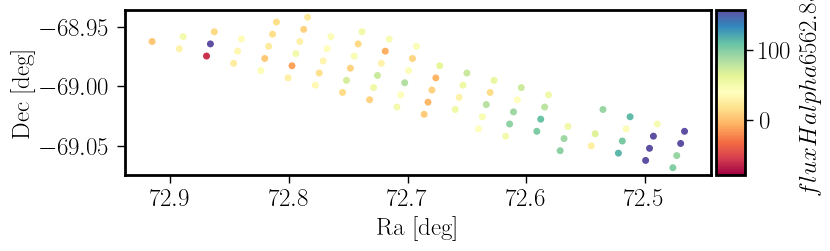

In [326]:
map_plot_DAP(tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk', size=16,\
             cmap='Spectral', fsize=8, figs_dir='figs')

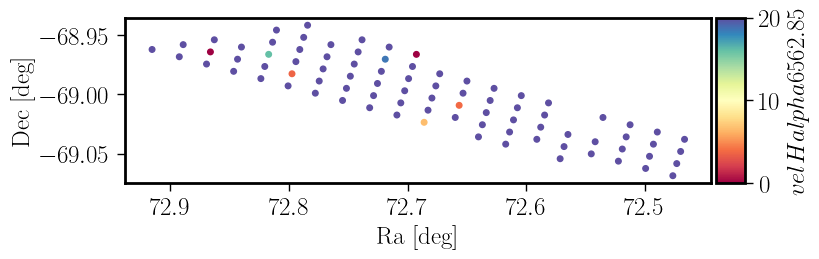

In [327]:
map_plot_DAP(tab_DAP,line='vel_Halpha_6562.85', \
                 vmin=0, vmax=20, title=None, filename='junk', size=16,\
             cmap='Spectral', fsize=8, figs_dir='figs')

-10 10


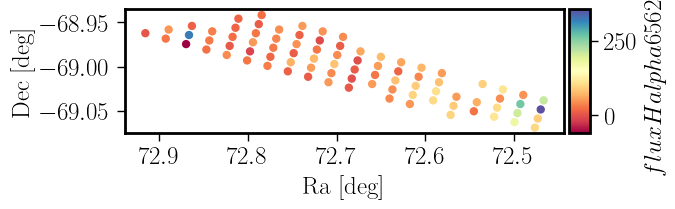

In [328]:
#line='flux_[OII]_3726.03'
line='flux_Halpha_6562.85'
tab_line = Table()
tab_line['ra_fib']=tab_DAP['ra']
tab_line['dec_fib']=tab_DAP['dec']
tab_line['line']=tab_DAP[line]
#print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
title=line.replace("_"," ")
print(v_min,v_max)
v_min=np.min(tab_line['line'])
v_max=np.max(tab_line['line'])
size=25
map_plot(tab_line, v_min, v_max, rf'${title}$', 'test_all',\
         size=size,cmap='Spectral',fsize=6)

-57.38883852308262 176.70039073970293


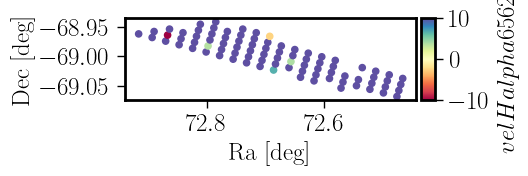

In [329]:
line='vel_Halpha_6562.85'
tab_line = Table()
tab_line['ra_fib']=tab_DAP['ra']
tab_line['dec_fib']=tab_DAP['dec']
tab_line['line']=tab_DAP[line]
#print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
title=line.replace("_"," ")
title=line.replace("_"," ")
v_min=-np.nanmean(tab_line['line'])
v_max=5*np.nanstd(tab_line['line'])
print(v_min,v_max)
v_min=-10
v_max=10
size=20
map_plot(tab_line, v_min, v_max, rf'${title}$', 'test_all',\
         size=size,cmap='Spectral',fsize=size/5)

In [330]:
line='vel_Ha_6562.817'

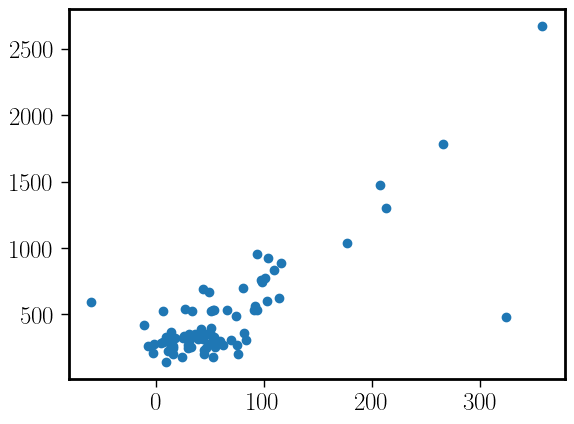

In [331]:
plt.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.68'])

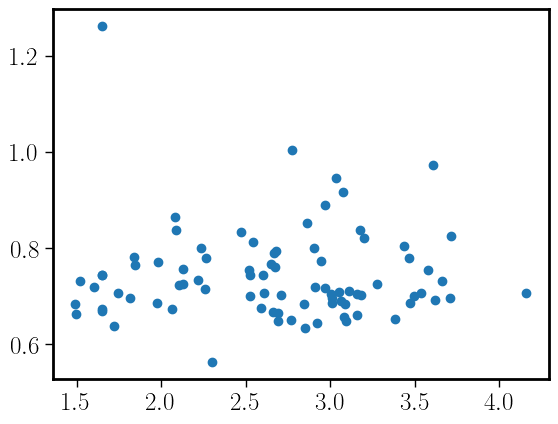

In [332]:
plt.scatter(np.sqrt(tab_DAP['disp_Halpha_6562.85']**2-1.5)/2.354,tab_DAP['disp_pe_6562.68'])

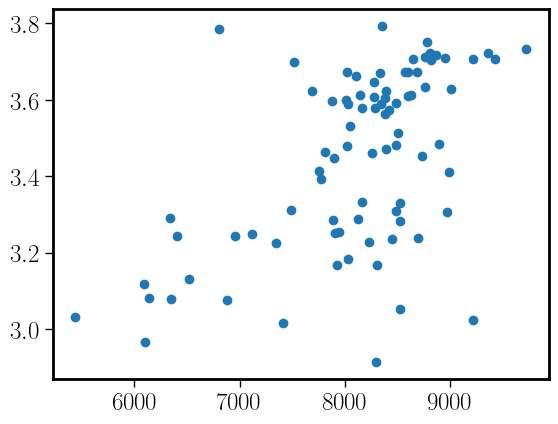

In [334]:
plt.scatter(tab_DAP['Teff'],tab_DAP['Log_g'])